# Carnet pour les analyses statistiques

## Définitions

In [33]:
from Data_tools import *

In [34]:
datas = []
n = 1000
for code in analysis_codes:
    query = f"""
    SELECT 
        l.valuenum, 
        l.storetime
    FROM 
        hosp.labevents l
    JOIN 
        hosp.d_labitems dl ON l.itemid = dl.itemid
    JOIN 
        hosp.patients p ON l.subject_id = p.subject_id
    WHERE 
        l.itemid = {code}
    ORDER BY 
        l.storetime
    LIMIT 
        {n};
"""

    df = execute_query(query, **params) 
    df["storetime"] = df["storetime"].apply(lambda x : x.date())
    datas.append(df)

# The values for the VGM are in the comments and must be treated so we don't use them
datas[2] = execute_query(f"SELECT p.anchor_age as valuenum FROM hosp.patients as p LIMIT {n}", **params)

___
## Partie 1 : analyses simples sur les variables

In [35]:
descriptions = []
for i in range(len(datas)) :
    d = datas[i].describe()
    print(analyses["label"][i])
    print(d)
    print("\n")
    descriptions.append(d)

Albumin
         valuenum
count  1000.00000
mean      3.56890
std       0.78418
min       1.20000
25%       2.90000
50%       3.60000
75%       4.20000
max       5.60000


Creatinine
          valuenum
count  1000.000000
mean      1.165500
std       0.849636
min       0.100000
25%       0.800000
50%       0.900000
75%       1.200000
max       9.000000


Patient age
          valuenum
count  1000.000000
mean     48.663000
std      20.943545
min      18.000000
25%      29.000000
50%      48.000000
75%      64.250000
max      91.000000


Potassium
         valuenum
count  999.000000
mean     4.113013
std      0.567746
min      1.700000
25%      3.700000
50%      4.100000
75%      4.400000
max      7.200000


Urea Nitrogen
         valuenum
count  1000.00000
mean     21.37800
std      16.47047
min       2.00000
25%      12.00000
50%      17.00000
75%      24.00000
max     136.00000




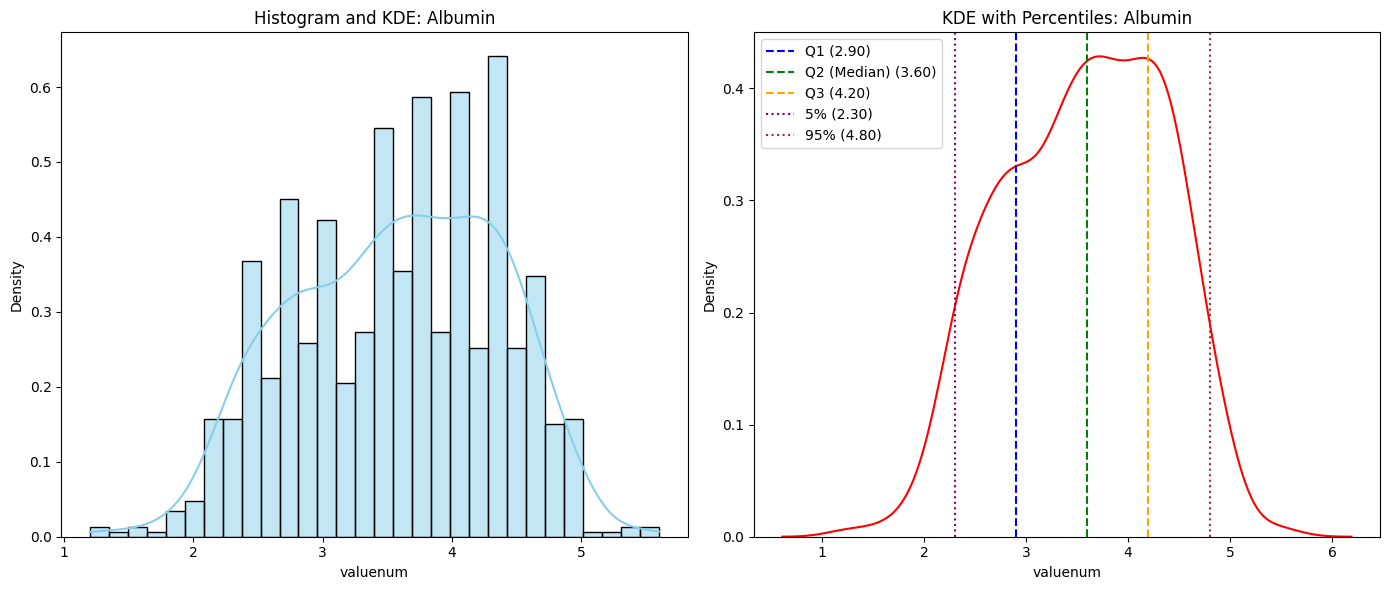

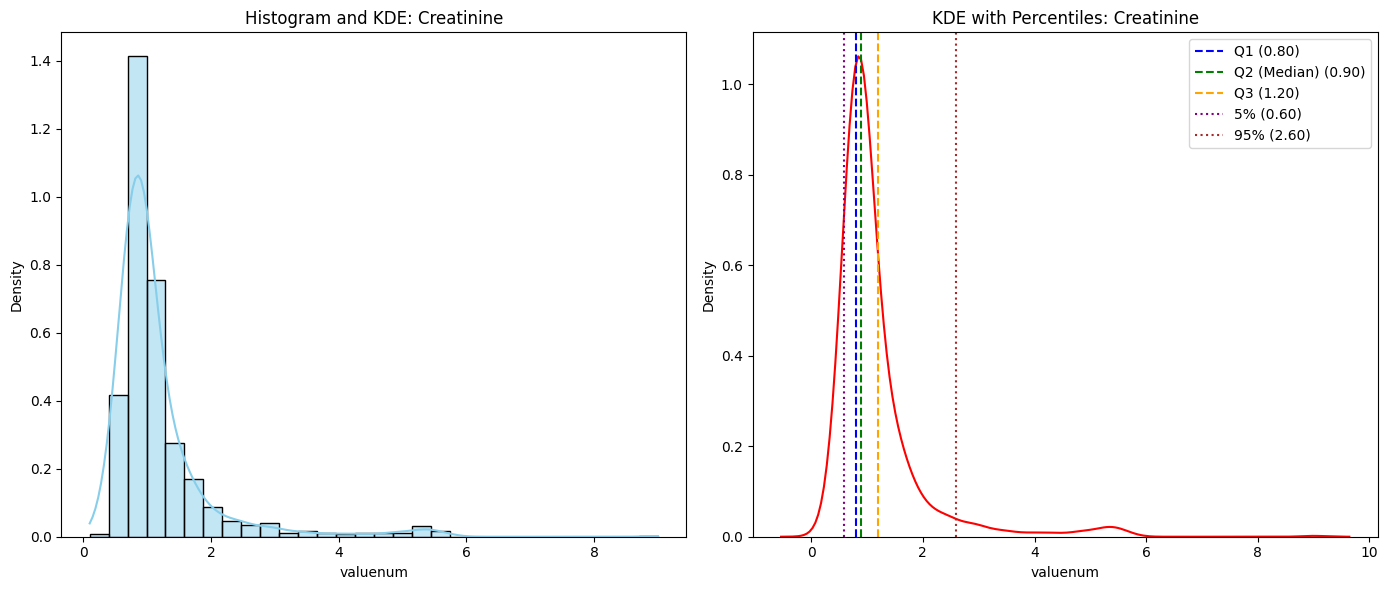

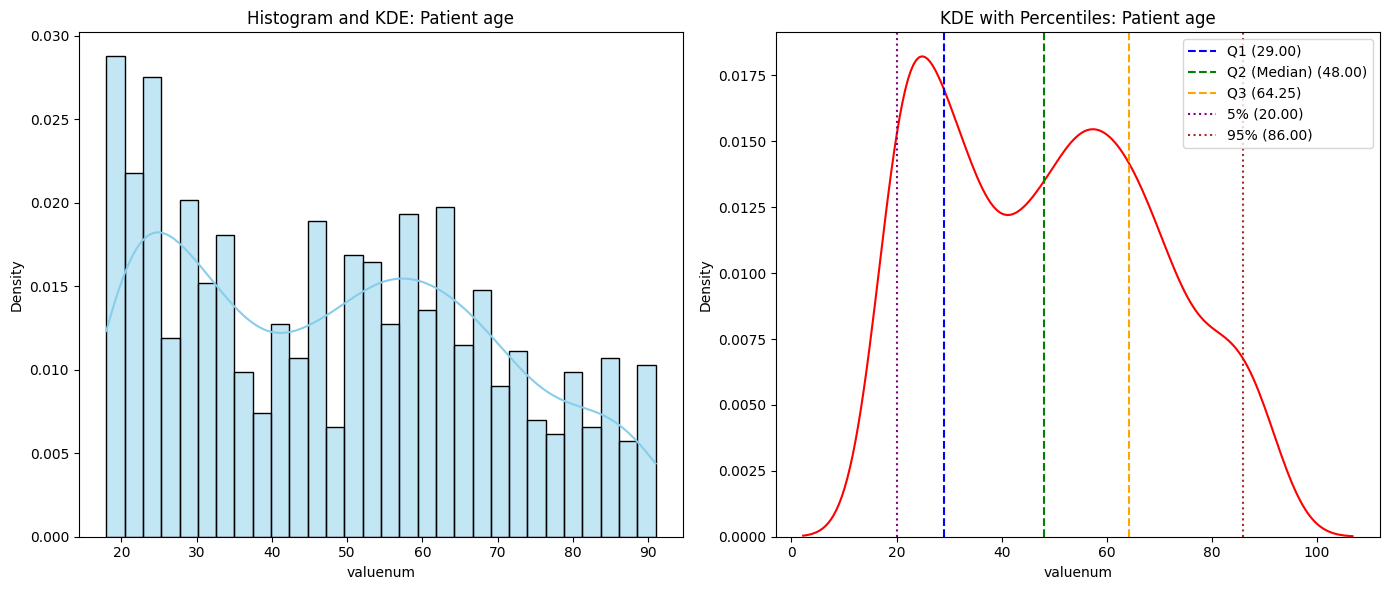

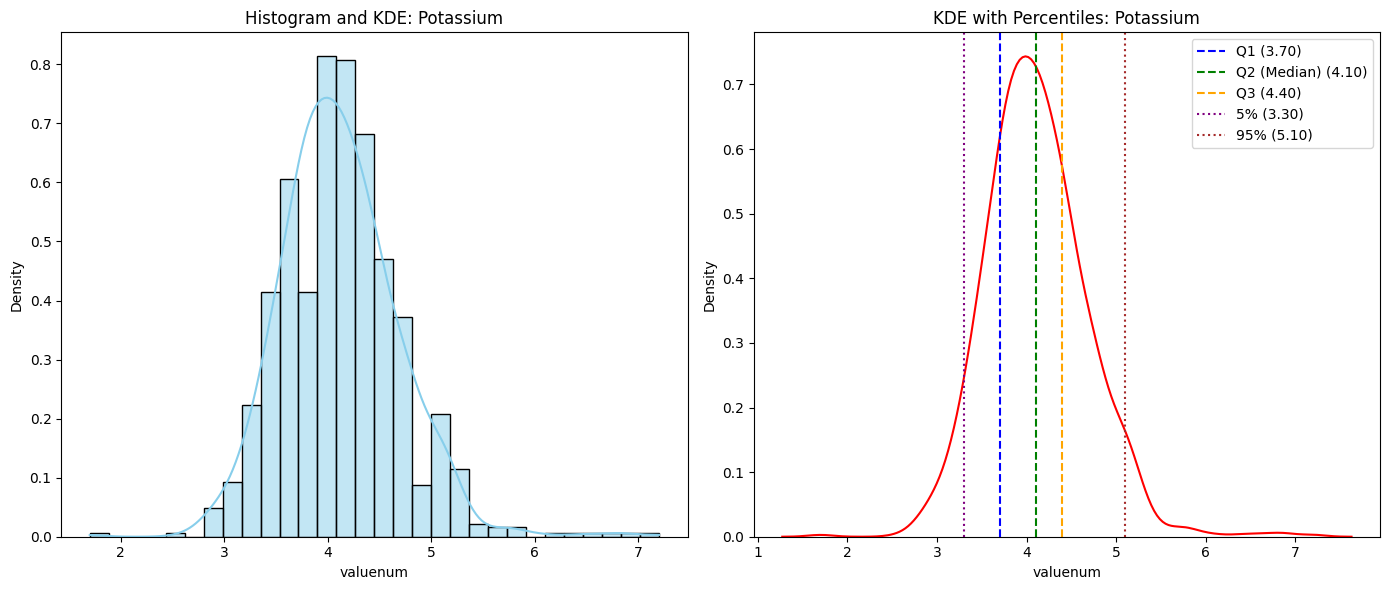

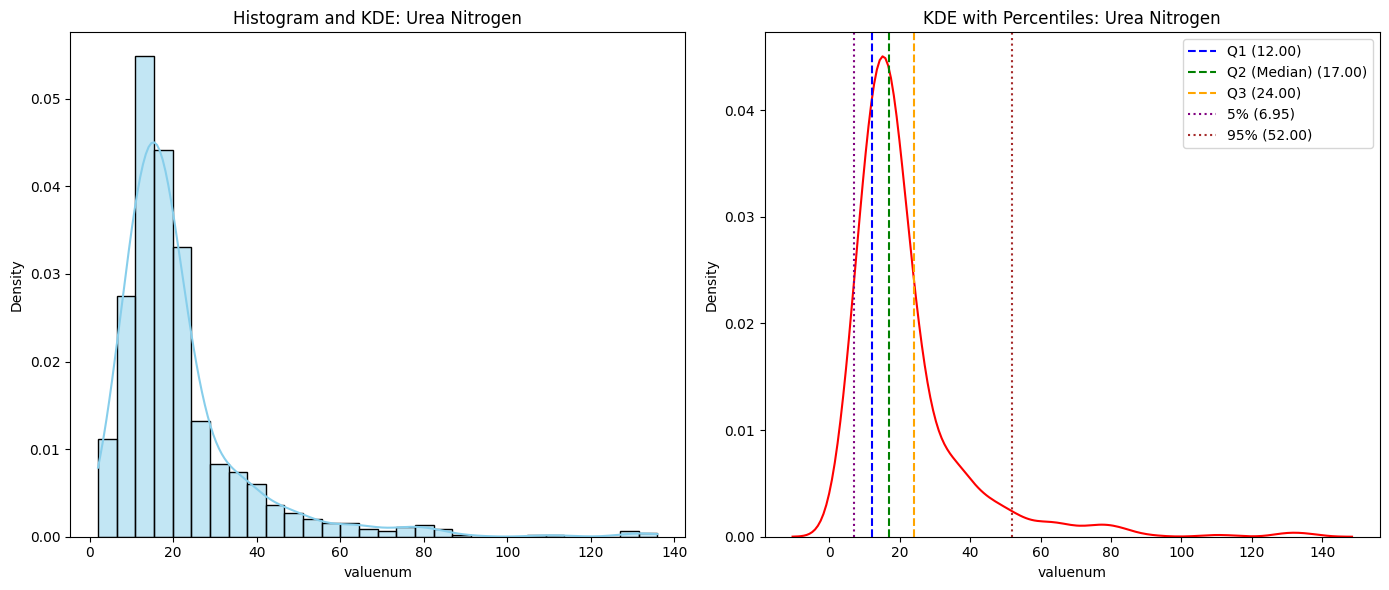

In [36]:
for i in range(len(datas)):
    # Create a figure with two columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # First column: Histogram and KDE
    sns.histplot(data=datas[i], x="valuenum", kde=True, ax=axes[0], color='skyblue', bins=30, stat='density')
    axes[0].set_title(f"Histogram and KDE: {analyses['label'][i]}")

    # Second column: KDE and Percentiles (p5, p95, Q1, Q2, Q3)
    sns.kdeplot(datas[i]["valuenum"], ax=axes[1], color='red')
    axes[1].set_title(f"KDE with Percentiles: {analyses['label'][i]}")

    # Calculate quartiles and percentiles
    Q1 = descriptions[i].loc['25%'].values[0]
    Q2 = descriptions[i].loc['50%'].values[0]  # Median
    Q3 = descriptions[i].loc['75%'].values[0]

    # Calculate the 5% and 95% percentiles
    p5 = np.nanpercentile(datas[i]["valuenum"], 5)
    p95 = np.nanpercentile(datas[i]["valuenum"], 95)

    # Add vertical lines for percentiles and quartiles to the second column
    axes[1].axvline(Q1, color='blue', linestyle='--', label=f"Q1 ({Q1:.2f})")
    axes[1].axvline(Q2, color='green', linestyle='--', label=f'Q2 (Median) ({Q2:.2f})')
    axes[1].axvline(Q3, color='orange', linestyle='--', label=f"Q3 ({Q3:.2f})")
    axes[1].axvline(p5, color='purple', linestyle=':', label=f'5% ({p5:.2f})')
    axes[1].axvline(p95, color='brown', linestyle=':', label=f'95% ({p95:.2f})')

    # Add a legend to the second column
    axes[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()


In [37]:
for i in range(len(datas)-1):
    miss = float(datas[i].isnull().mean()["valuenum"]) * 100
    print(f"{miss} % of the values are missing for the analysis : {analyses["label"][i]}")

0.0 % of the values are missing for the analysis : Albumin
0.0 % of the values are missing for the analysis : Creatinine
0.0 % of the values are missing for the analysis : Patient age
0.1 % of the values are missing for the analysis : Potassium


In [38]:
[ 'Albumin', 'Creatinine', 'Potassium', 'Patient age', 'Urea Nitrogen']

['Albumin', 'Creatinine', 'Potassium', 'Patient age', 'Urea Nitrogen']

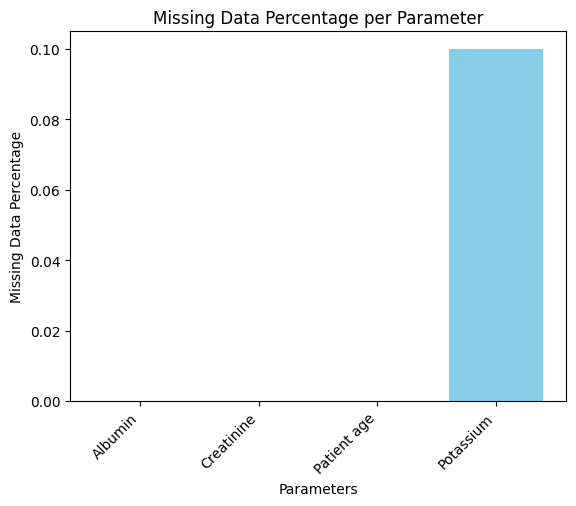

In [39]:
# The list of missing data percentages
l_miss = []

# The custom labels for each bar
labels = []

for i in range(len(datas)-1):
    l_miss.append(float(datas[i].isnull().mean()["valuenum"]) * 100)
    labels.append(analyses["label"][i])

# Create a bar chart
plt.bar(labels, l_miss, color='skyblue')

# Adding labels and title
plt.xlabel('Parameters')
plt.ylabel('Missing Data Percentage')
plt.title('Missing Data Percentage per Parameter')

# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.show()


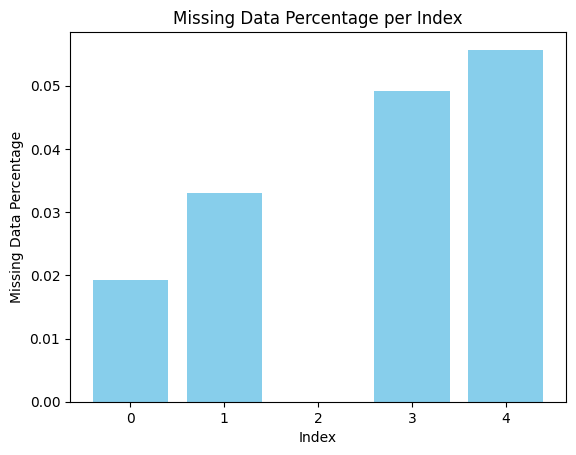

In [40]:
l_miss = [0.019201433707050127, 0.033, 0.0, 0.0492, 0.0557]

# Create a bar chart
plt.bar(range(len(l_miss)), l_miss, color='skyblue')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Missing Data Percentage')
plt.title('Missing Data Percentage per Index')

# Show the plot
plt.show()


In [41]:
datas[2].describe()

,valuenum
count,1000.000000
mean,48.663000
std,20.943545
min,18.000000
25%,29.000000
50%,48.000000
75%,64.250000
max,91.000000


In [42]:
datas[0].describe()

,valuenum
count,1000.00000
mean,3.56890
std,0.78418
min,1.20000
25%,2.90000
50%,3.60000
75%,4.20000
max,5.60000


___
## Partie 2 : analyses des relations entre les variables

In [43]:
query = f"""
SELECT 
    l.valuenum, 
    l.storetime, 
    l.itemid, 
    dl.label,
    l.subject_id 
FROM hosp.labevents l 
JOIN hosp.d_labitems dl 
    ON l.itemid = dl.itemid 
JOIN hosp.patients p 
    ON l.subject_id = p.subject_id 
WHERE l.itemid IN {sqlify(analysis_codes)} 
ORDER BY l.storetime 
LIMIT {n};
"""

df0 = execute_query(query, **params)

df0

,valuenum,storetime,itemid,label,subject_id
0,2.4,2105-10-04 18:17:00,50862,Albumin,16904137
1,1.1,2105-10-04 18:17:00,50912,Creatinine,16904137
2,3.8,2105-10-04 18:17:00,50971,Potassium,16904137
3,24.0,2105-10-04 18:17:00,51006,Urea Nitrogen,16904137
4,1.0,2105-10-05 02:59:00,50912,Creatinine,16904137
...,...,...,...,...,...
995,20.0,2109-10-03 15:23:00,51006,Urea Nitrogen,15894414
996,3.8,2109-10-03 15:23:00,50862,Albumin,15894414
997,1.3,2109-10-03 15:23:00,50912,Creatinine,15894414
998,0.6,2109-10-03 16:53:00,50912,Creatinine,19174117


### Co-occurences heatmap

The goal here is to find whether some measurements are often made together, or are very separately made. This is motivated by the fact that if we want to constitute a profile of the patient at a date t, it would be better if all the measurements had been made at the same date t, but there is no warranty this ever happens.

label          Creatinine  Urea Nitrogen  Potassium  Albumin
label                                                       
Creatinine            0.0            0.0        0.0      0.0
Urea Nitrogen         0.0            0.0        0.0      0.0
Potassium             0.0            0.0        0.0      0.0
Albumin               0.0            0.0        0.0      0.0


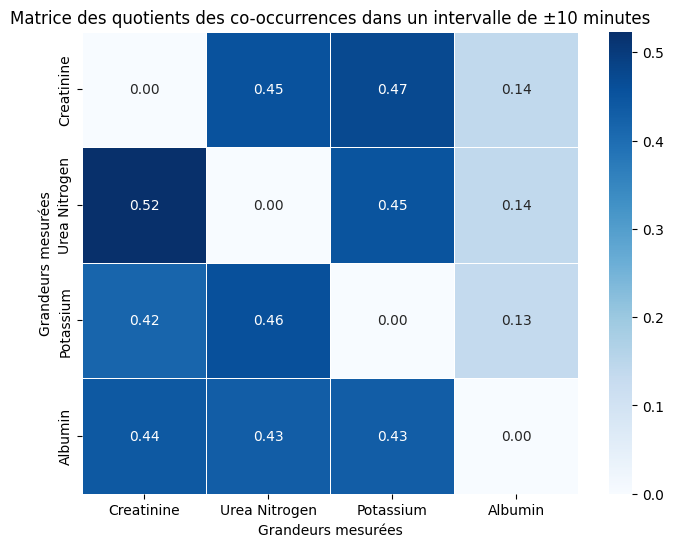

In [44]:

total_counts0 = df0['label'].value_counts()
# Creation of a matrix to save the quotients of co-occurences

grandeurs0 = total_counts0.index
matrix0 = pd.DataFrame(0.0, index=grandeurs0, columns=grandeurs0)
print(matrix0)

# Use of the sliding window method to count co-occurences
start = 0
for end in range(len(df0)):
    
    # Finds the 10 min window
    date_1 = df0.iloc[end]['storetime']
    date_2 = df0.iloc[start]['storetime']
    delta_dates = date_1 - date_2
    while delta_dates.total_seconds() > 600 :
        start += 1  # Déplacer 'start' pour exclure les éléments trop anciens
        date_2 = df0.iloc[start]['storetime']
        delta_dates = date_1 - date_2

    # Counts the co-occurences in the window
    for i in range(start, end):
        grandeur_1 = df0.iloc[i]['label']
        patient_number_1 = df0.iloc[i]['subject_id']
        grandeur_2 = df0.iloc[end]['label']
        patient_number_2 = df0.iloc[end]['subject_id']
        if  patient_number_1 == patient_number_2 and grandeur_1 != grandeur_2 :
            matrix0.at[grandeur_1, grandeur_2] += 1

# Normalizing by the count of total appearances of each quantity
for grandeur in grandeurs0:
    matrix0.loc[grandeur] /= total_counts0[grandeur]

# Plotting the heatmap with seaborne
plt.figure(figsize=(8, 6))
sns.heatmap(matrix0, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Matrice des quotients des co-occurrences dans un intervalle de ±10 minutes")
plt.xlabel("Grandeurs mesurées")
plt.ylabel("Grandeurs mesurées")
plt.show()


### Distplots

In [45]:
grandeurs0 = ['Creatinine', 'Urea Nitrogen', 'Potassium', 'Albumin']
# Separate the columns that need to be pivoted and the ones to remain unchanged
df_measurements = df0[['label', 'valuenum']]  # Columns related to the measurements
df_other = df0.drop(columns=['label', 'valuenum'])  # All other columns to remain unchanged

# Pivoting the measurement-related DataFrame
df_separated = df_measurements.pivot(columns='label', values='valuenum')

# Reorder columns in the correct order (if needed)
df_separated = df_separated[grandeurs0]  # 'grandeurs0' contains the correct order of labels

# If any measurement is missing, it will be represented as np.nan
df_separated = df_separated.fillna(np.nan)

# Merge the pivoted data back with the remaining columns (those not pivoted)
df_final = pd.concat([df_separated, df_other], axis=1)

# Display the result
df_final


,Creatinine,Urea Nitrogen,Potassium,Albumin,storetime,itemid,subject_id
0,NaN,NaN,NaN,2.4,2105-10-04 18:17:00,50862,16904137
1,1.1,NaN,NaN,NaN,2105-10-04 18:17:00,50912,16904137
2,NaN,NaN,3.8,NaN,2105-10-04 18:17:00,50971,16904137
3,NaN,24.0,NaN,NaN,2105-10-04 18:17:00,51006,16904137
4,1.0,NaN,NaN,NaN,2105-10-05 02:59:00,50912,16904137
...,...,...,...,...,...,...,...
995,NaN,20.0,NaN,NaN,2109-10-03 15:23:00,51006,15894414
996,NaN,NaN,NaN,3.8,2109-10-03 15:23:00,50862,15894414
997,1.3,NaN,NaN,NaN,2109-10-03 15:23:00,50912,15894414
998,0.6,NaN,NaN,NaN,2109-10-03 16:53:00,50912,19174117


The goal of the following piece of code is to constitute profiles of the patients at a date t, by shuffling measurement made close from one another.

In [46]:
from itertools import permutations

# Initialize variables for the result
result_rows = []

# Group the DataFrame by subject_id so that we only process measurements per patient
for subject_id, df_patient in df0.groupby("subject_id"):
    # Sort the patient data by storetime
    df_patient = df_patient.sort_values("storetime").reset_index(drop=True)
    
    # Process the patient’s measurements in time windows (10 minutes)
    i = 0
    while i < len(df_patient):
        # Start a time-window group from the current row
        group = [df_patient.iloc[i]]
        group_start_time = group[0]['storetime']
        
        # Add subsequent rows if they fall within 10 minutes of the start of the group
        j = i + 1
        while j < len(df_patient):
            time_diff = (df_patient.iloc[j]['storetime'] - group_start_time).total_seconds()
            if time_diff <= 600:  # 10 minutes = 600 seconds
                group.append(df_patient.iloc[j])
                j += 1
            else:
                break
        
        # Define the full set of measurement types (assumed to be in grandeurs0)
        measurement_types = grandeurs0
        measurements_in_group = {label: np.nan for label in measurement_types}
        
        # For the measurements in the current group, record the available values
        for row in group:
            measurements_in_group[row['label']] = row['valuenum']
        
        # Filter out measurements that are missing
        non_na_measurements = {key: value for key, value in measurements_in_group.items() if not pd.isna(value)}
        
        if non_na_measurements:
            # Generate all possible combinations (permutations) of the available measurements
            for comb in permutations(non_na_measurements.items(), len(non_na_measurements)):
                new_row = {
                    'storetime': group[0]['storetime'],  # use the group's starting time
                    'subject_id': subject_id             # include the patient ID
                }
                # Add each measurement from the permutation to the new row
                for idx, (label, val) in enumerate(comb):
                    new_row[label] = val
                
                # Ensure all measurement types are present (fill missing ones with NaN)
                for label in measurement_types:
                    if label not in new_row:
                        new_row[label] = np.nan
                
                # Add the newly constructed row to the result list
                result_rows.append(new_row)
        
        # Move to the next time window for this patient
        i = j

# Convert the result list of rows into a DataFrame,
# then drop duplicates and remove the 'storetime' column if no longer needed
df_final = pd.DataFrame(result_rows).drop_duplicates().drop(columns="storetime")

# Display the final DataFrame
df_final


,subject_id,Creatinine,Urea Nitrogen,Potassium,Albumin
0,10101340,0.9,22.0,4.1,4.1
24,10101340,1.1,25.0,NaN,NaN
26,10169933,1.0,16.0,4.3,4.3
50,10169933,1.1,26.0,4.4,4.5
74,10269629,0.9,10.0,4.2,NaN
...,...,...,...,...,...
3161,19676141,1.4,23.0,4.9,NaN
3167,19816707,0.7,17.0,NaN,4.1
3173,19816707,0.6,17.0,NaN,4.2
3179,19833877,0.7,19.0,NaN,NaN


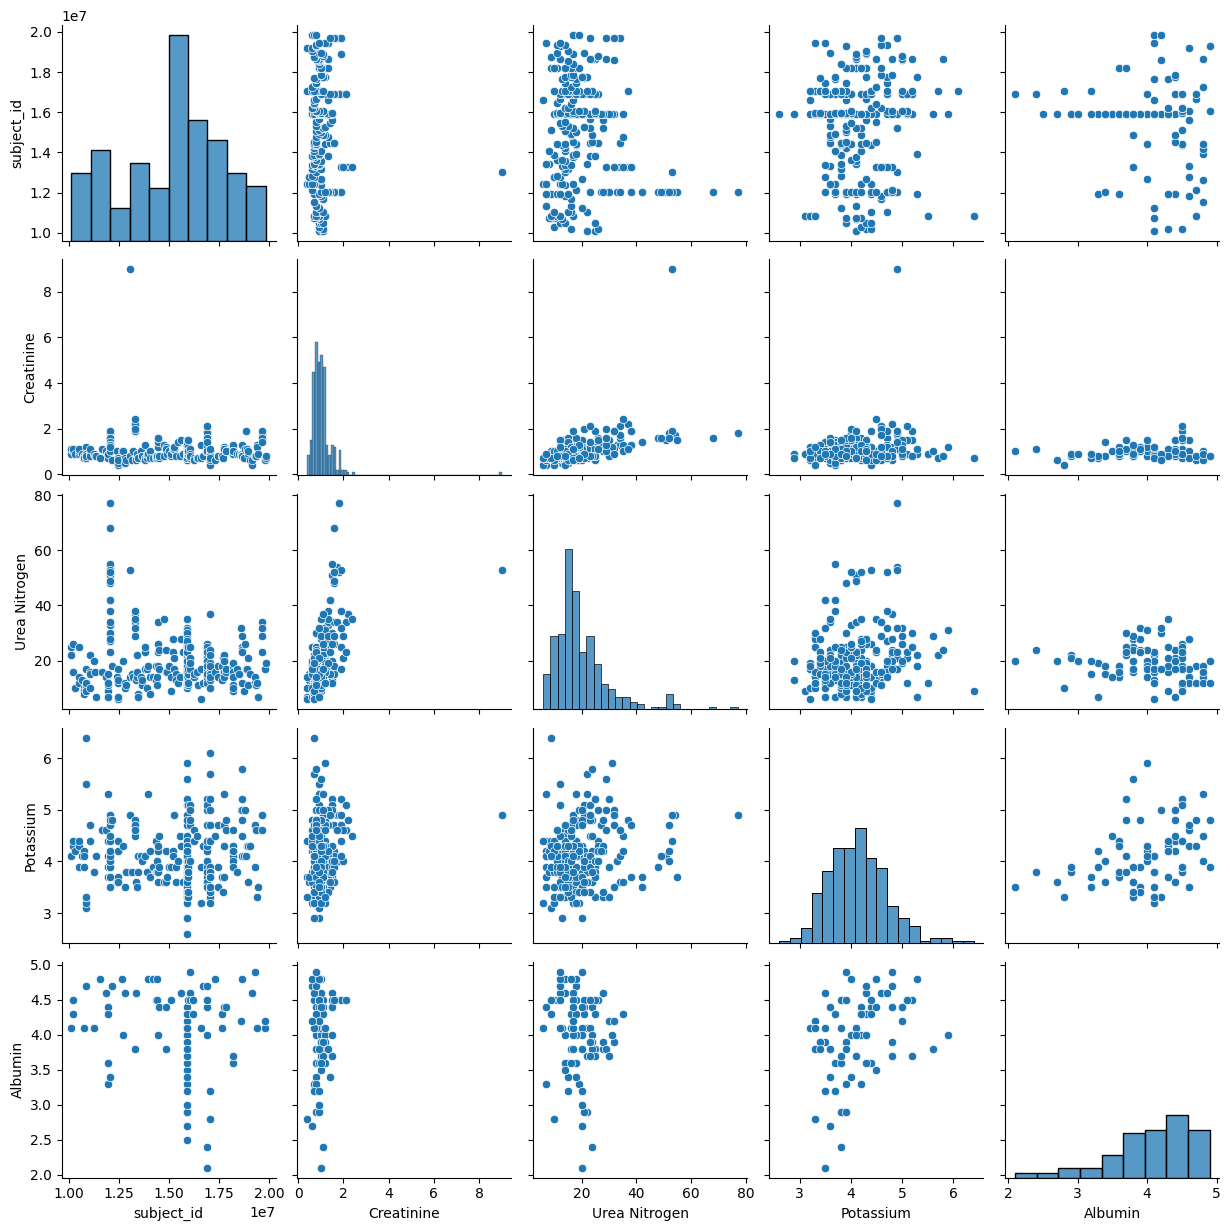

In [47]:
sns.pairplot(data=df_final)

Text(0.5, 1.0, 'Correlation Heatmap')

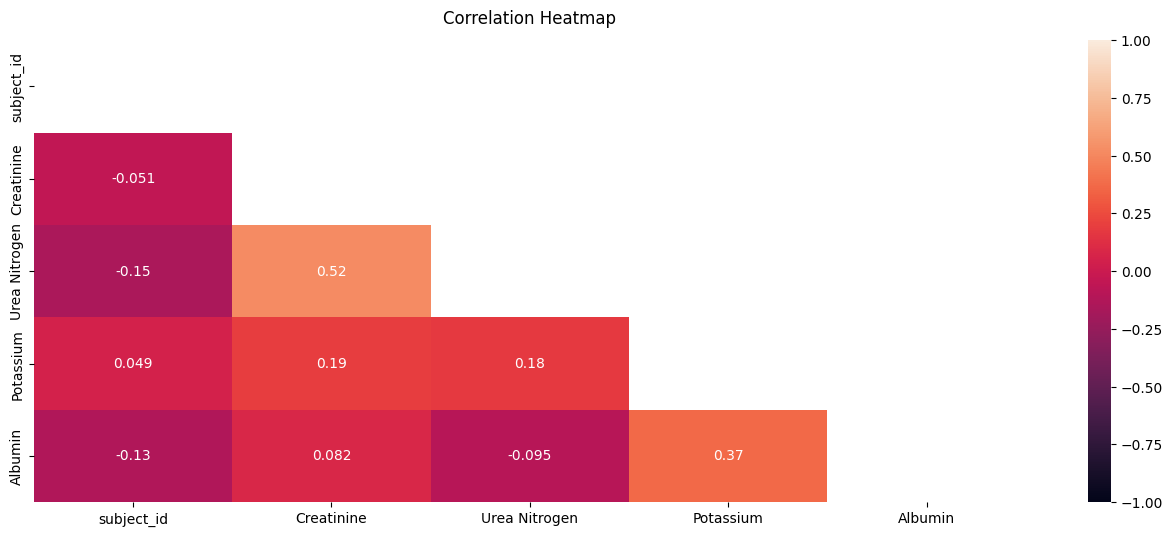

In [48]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_final.corr(), dtype=np.bool))
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_final.corr(), vmin=-1, vmax=1, mask=mask, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [49]:
n = 1000000

In [50]:

code_list_formatted = "(" + ", ".join(analysis_codes) +")"
print(code_list_formatted)
query = f"""
SELECT 
    l.valuenum, 
    l.storetime, 
    l.itemid, 
    dl.label 
FROM hosp.labevents l 
JOIN hosp.d_labitems dl 
    ON l.itemid = dl.itemid 
JOIN hosp.patients p 
    ON l.subject_id = p.subject_id 
WHERE l.itemid IN {code_list_formatted} 
LIMIT {n};
"""

df1 = execute_query(query, **params) 
datas.append(df1)
df1

(50862, 50912, 0, 50971, 51006)


,valuenum,storetime,itemid,label
0,12.0,2139-04-28 22:31:00,51006,Urea Nitrogen
1,0.5,2139-04-29 06:26:00,50912,Creatinine
2,4.0,2139-04-29 06:26:00,50971,Potassium
3,12.0,2139-04-29 06:26:00,51006,Urea Nitrogen
4,0.5,2139-04-30 07:39:00,50912,Creatinine
...,...,...,...,...
999995,71.0,2126-07-15 19:55:00,51006,Urea Nitrogen
999996,4.3,2126-10-06 18:41:00,50862,Albumin
999997,4.0,2126-10-06 18:41:00,50912,Creatinine
999998,3.9,2126-10-06 18:41:00,50971,Potassium


In [51]:
df_separated = separate_values(df1, grandeurs0)
df_separated


,Creatinine,Urea Nitrogen,Potassium,Albumin,storetime,itemid
0,NaN,12.0,NaN,NaN,2139-04-28 22:31:00,51006
1,0.5,NaN,NaN,NaN,2139-04-29 06:26:00,50912
2,NaN,NaN,4.0,NaN,2139-04-29 06:26:00,50971
3,NaN,12.0,NaN,NaN,2139-04-29 06:26:00,51006
4,0.5,NaN,NaN,NaN,2139-04-30 07:39:00,50912
...,...,...,...,...,...,...
999995,NaN,71.0,NaN,NaN,2126-07-15 19:55:00,51006
999996,NaN,NaN,NaN,4.3,2126-10-06 18:41:00,50862
999997,4.0,NaN,NaN,NaN,2126-10-06 18:41:00,50912
999998,NaN,NaN,3.9,NaN,2126-10-06 18:41:00,50971


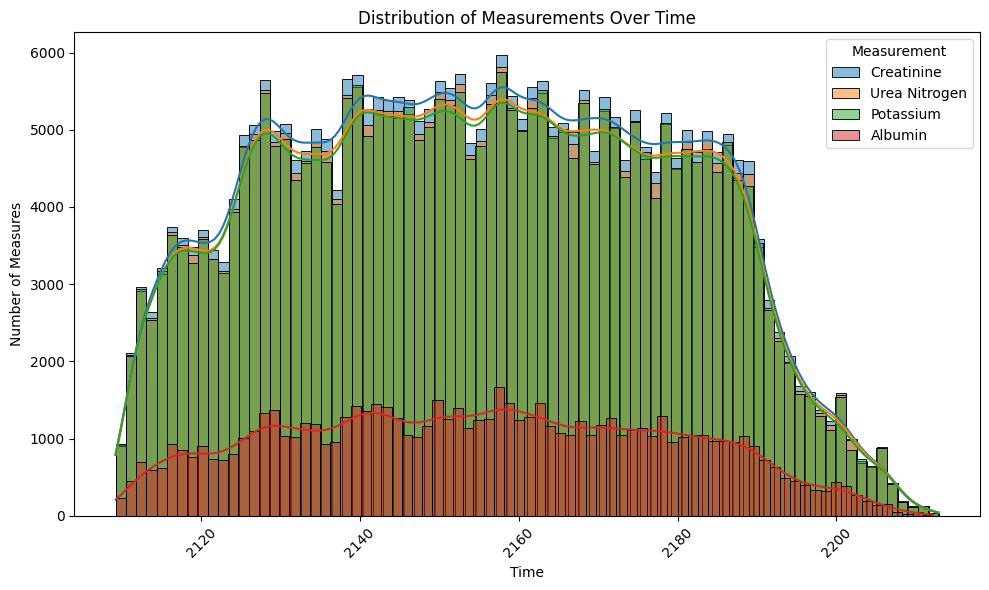

In [52]:
def rm(i, l):
    return l[:i] + l[i+1:]

# Create a single figure (1 graph)
plt.figure(figsize=(10, 6))

# Define the measurements
labels = ['Creatinine', 'Urea Nitrogen', 'Potassium', 'Albumin']

# Loop over the labels to plot each measurement on the same graph
for i, label in enumerate(labels):
    # Filter data for the current measurement
    data = df_separated.dropna(subset=[label])
    data = data.drop(columns=rm(i, labels) + ['itemid'])
    
    # Create the histplot for the current measurement
    sns.histplot(data=data, x='storetime', kde=True, bins=80, label=label)

# Set title and labels
plt.title('Distribution of Measurements Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Measures')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a legend to identify the measurements
plt.legend(title='Measurement')

# Show the plot
plt.tight_layout()
plt.show()
